In [2]:
pip install pandas

     |████████████████████████████████| 9.9 MB 785 kB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyarrow

     |████████████████████████████████| 17.7 MB 2.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install fiona

     |████████████████████████████████| 14.8 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 396 kB/s eta 0:00:01
     |████████████████████████████████| 147 kB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pygeos

     |████████████████████████████████| 1.6 MB 1.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install rtree

     |████████████████████████████████| 994 kB 923 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install geopandas

     |████████████████████████████████| 962 kB 443 kB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 1.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install prefect

     |████████████████████████████████| 476 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 884 kB 468 kB/s eta 0:00:01
     |████████████████████████████████| 669 kB 680 kB/s eta 0:00:01
     |████████████████████████████████| 146 kB 940 kB/s eta 0:00:01
     |████████████████████████████████| 46 kB 684 kB/s eta 0:00:01
     |████████████████████████████████| 273 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 489 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 467 kB/s eta 0:00:01
     |████████████████████████████████| 178 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 640 kB

In [10]:
pip install matplotlib

     |████████████████████████████████| 11.6 MB 54 kB/s  eta 0:00:01    |█▏                              | 419 kB 1.2 MB/s eta 0:00:10
     |████████████████████████████████| 1.1 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 355 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [81]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
from prefect import Flow
from prefect import task

In [83]:
@task
def _read_sa_parquet(input_filepath: str) -> pd.DataFrame:

    return pd.read_parquet(input_filepath).drop_duplicates()


@task
def _read_sa_geometries(input_filepath: str) -> gpd.GeoDataFrame:

    return gpd.read_parquet(input_filepath)


@task
def _read_ed_geometries(input_filepath: str) -> pd.DataFrame:

    return gpd.read_file(input_filepath)


@task
def _read_csv(input_filepath: str) -> pd.DataFrame:

    return pd.read_csv(input_filepath, encoding="unicode_escape").drop_duplicates()


@task
def _read_energy_csv(input_filepath: str) -> pd.DataFrame:

    return pd.read_csv(input_filepath)


@task
def _extract_ber_dublin(df: pd.DataFrame, on: str, contains: str) -> pd.DataFrame:

    return df[df[on].str.contains(contains)]


@task
def _set_postcodes_to_lowercase(df: pd.DataFrame, new: str, old: str) -> pd.DataFrame:

    df[new] = df[old].str.lower()

    return df


@task
def _merge_ber_sa(
    left: pd.DataFrame, right: pd.DataFrame, left_on: str, right_on: str, **kwargs,
) -> pd.DataFrame:

    return left.merge(right, left_on=left_on, right_on=right_on, **kwargs)


@task
def _merge_cso_ed(
    left: pd.DataFrame, right: pd.DataFrame, left_on: str, right_on: str, **kwargs,
) -> pd.DataFrame:

    return left.merge(right, left_on=left_on, right_on=right_on, **kwargs)


@task
def _extract_cso_columns(
    df: pd.DataFrame, ed: str, res: str, geometry: str,
) -> pd.DataFrame:

    return df[[ed, res, geometry]]


@task
def _split_ber_by_year_of_construction(
    df: pd.DataFrame, condition: str,
) -> pd.DataFrame:

    return df.query(condition).drop_duplicates()


@task
def _spatial_join(
    left: gpd.GeoDataFrame, right: pd.DataFrame, **kwargs,
) -> gpd.GeoDataFrame:

    right = gpd.GeoDataFrame(right)
    right = right.to_crs(epsg="4326")

    return gpd.sjoin(left, right, **kwargs)


@task
def _allocate_duplicates(df: pd.DataFrame) -> pd.DataFrame:

    df["counts"] = df.ed_lower.groupby(df.ed_lower).transform("count")
    df["real_resi"] = df["total_resi_ed"] * (1 / df["counts"])

    return df


@task
def _assign_building_type(df: pd.DataFrame, on: str, equiv: list) -> pd.DataFrame:

    return df.replace({on: equiv})


@task
def _assign_energy_rating_to_numerical(
    df: pd.DataFrame, number: str, rating: str, equiv: list,
) -> pd.DataFrame:

    df[number] = df[rating].map(equiv)

    return df


@task
def _count_resi_buildings_in_each_postcode_on_column(
    gdf: gpd.GeoDataFrame, on: str, renamed: str,
) -> pd.DataFrame:

    return gdf[[on]].value_counts().rename(renamed).reset_index()


@task
def _apply_ber_rating_split(
    df: pd.DataFrame,
    small_area: str,
    year_of_construction: str,
    split: str,
    year: int,
    post: str,
    pre: str,
    pre_post: str,
) -> pd.DataFrame:

    df = df.groupby([small_area, year_of_construction])
    df = df.head(300000)
    df[year_of_construction] = df[year_of_construction].astype(int)
    df[split] = np.where(df[year_of_construction] <= year, post, pre)
    df = df.groupby(small_area)[split].value_counts(normalize=True)
    df = df.to_frame()
    df = df.rename(columns={split: pre_post})

    return df.reset_index()


@task
def _count_buildings_by_ed(
    df: pd.DataFrame, by: str, on: str, renamed: str,
) -> pd.DataFrame:

    return df.groupby(by)[on].sum().rename(renamed).reset_index()


@task
def _count_buildings_by_pcode(df: pd.DataFrame, by: str, on: str) -> pd.DataFrame:

    return df.groupby(by)[on].sum().reset_index()


@task
def _count_buildings_by_sa(
    df: pd.DataFrame, by: str, on: str, renamed: str,
) -> pd.DataFrame:

    return df.groupby(by)[on].value_counts(normalize=True).rename(renamed).reset_index()


@task
def _calculate_split_buildings_per_postcode(
    df: pd.DataFrame, total: str, count: str, ratio: str,
) -> pd.DataFrame:

    df[total] = df[count] * df[ratio]

    return df


@task
def _calculate_demand_per_postcode(
    df: pd.DataFrame, total: str, count: str, ratio: str,
) -> pd.DataFrame:

    df[total] = df[count] * df[ratio]

    return df


@task
def _match_building_description_to_energyplus(
    df: pd.DataFrame, new: str, left: str, right: str,
) -> pd.DataFrame:

    df[new] = df[left] + df[right]

    return df


@task
def _calculate_energy_by_postcode(
    df: pd.DataFrame, by: str, on: str, renamed: str,
) -> pd.DataFrame:

    return df.groupby(by)[on].sum().rename(renamed).reset_index()


@task
def _merge_postcode_geometries(
    left: pd.DataFrame, right: pd.DataFrame, left_on: str, right_on: str, **kwargs,
) -> pd.DataFrame:

    return left.merge(right, left_on=left_on, right_on=right_on, **kwargs)


@task
def _extract_plotting_columns(
    df: pd.DataFrame, postcode: str, energy: str, geometry: str,
) -> pd.DataFrame:

    return df[[postcode, energy, geometry]]


@task
def _merge_result(
    energy: pd.DataFrame,
    elec: pd.DataFrame,
    heat: pd.DataFrame,
    on: str,
) -> pd.DataFrame:

    return energy.merge(elec, on=on).merge(heat, on=on)


@task
def _create_shapefile(df: pd.DataFrame, driver: str, path: str) -> gpd.GeoDataFrame:

    gdf = gpd.GeoDataFrame(df)

    return gdf.to_file(driver=driver, filename=path)


@task
def _convert_postcode_to_sa(df: pd.DataFrame) -> pd.DataFrame:

    df_loc = df.iloc[:, 310:339]
    df_loc["sum"] = df_loc.sum(axis=1)
    df = pd.DataFrame(df["GEOGID"])
    df_sum = pd.concat([df, df_loc], axis=1)
    df_tot = df_sum[["GEOGID", "sum"]]
    df_tot["GEOGID"] = df_tot["GEOGID"].str.replace("SA2017_", "")

    return df_tot


@task
def _small_area_centroid_join(
    df: pd.DataFrame, pcode: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:

    gdf = gpd.GeoDataFrame(df)
    gdf["centroids"] = gdf.geometry.centroid
    df_ext = gdf[["GEOGID", "sum", "centroids"]]
    df_ext = df_ext.rename(columns={"centroids": "geometry"})
    gdf = gpd.GeoDataFrame(df_ext)
    gdf = gdf.set_crs(epsg="4326")
    gdf2 = gpd.GeoDataFrame(pcode)

    return gpd.sjoin(gdf, gdf2, op="within")


@task
def _compute_sa_demands(df: pd.DataFrame) -> pd.DataFrame:

    df = df.groupby("postcodes")["sum"].sum()

    return pd.DataFrame(df).reset_index()


@task
def _link_sa_pcode_count(df: pd.DataFrame) -> pd.DataFrame:

    df["portion"] = df["sum_x"] / df["sum_y"]
    df["sa_demand_kwh"] = df["energy_per_postcode_kwh"] * df["portion"]

    return df[["GEOGID", "sa_demand_kwh", "geometry"]]


@task
def _link_sa_centroids_geom(demand: pd.DataFrame, geom: pd.DataFrame) -> pd.DataFrame:

    df = demand.merge(geom, left_on="GEOGID", right_on="small_area", how="inner")
    df = df.rename(columns={"geometry_y": "geometry"})

    return df[["GEOGID", "sa_demand_kwh", "geometry"]]


@task
def _convert_kw_to_kva(df: pd.DataFrame) -> pd.DataFrame:
    
    df["peak_elec_demand(kW)"] = df["peak_hourly_elec_demand(J)"]/3600000
    df["peak_elec_demand(kVA)"] = df["peak_elec_demand(kW)"]*0.85
    
    return df

In [99]:
with Flow("Create synthetic residential building stock") as flow:

    dublin_post = _read_sa_parquet("idf/resi_modelling/dublin_postcodes.parquet")
    post_geom = _read_sa_geometries("idf/resi_modelling/dublin_postcodes.parquet")
    ber = _read_csv("idf/resi_modelling/BER.09.06.2020.csv")
    ed_geom = _read_ed_geometries("idf/resi_modelling/dublin_ed_geometries.shp")
    cso_crosstab = _read_csv("idf/resi_modelling/census2016_ed_crosstab.csv")
    ber_dublin = _extract_ber_dublin(ber, on="CountyName2", contains="DUBLIN")
    ber_dub_lower = _set_postcodes_to_lowercase(
        ber_dublin, new="postcode", old="CountyName2",
    )
    dublin_post_lower = _set_postcodes_to_lowercase(
        dublin_post, new="postcode", old="postcodes",
    )
    post_geom_lower = _set_postcodes_to_lowercase(
        post_geom, new="postcode", old="postcodes",
    )
    cso_geom_total = _count_buildings_by_ed(
        cso_crosstab, by="ed_2016", on="value_2016_inferred", renamed="total_resi_ed",
    )
    ed_lower = _set_postcodes_to_lowercase(ed_geom, new="ed_lower", old="ED_ENGLISH")
    ed_merged = _merge_cso_ed(
        left=cso_geom_total,
        right=ed_lower,
        left_on="ed_2016",
        right_on="ed_lower",
        how="inner",
    )
    cso_extracted = _extract_cso_columns(
        ed_merged, ed="ed_lower", res="total_resi_ed", geometry="geometry",
    )
    cso_postcode = _spatial_join(left=post_geom, right=cso_extracted, how="right")
    cso_dropped = _allocate_duplicates(cso_postcode)
    cso_final = _count_buildings_by_ed(
        cso_dropped, by="postcode", on="real_resi", renamed="res_per_postcode",
    )
    ber_postcode = _merge_ber_sa(
        left=dublin_post_lower,
        right=ber_dub_lower,
        left_on="postcode",
        right_on="postcode",
        how="inner",
        indicator=True,
    )
    ber_numbered = _assign_energy_rating_to_numerical(
        ber_postcode,
        number="Energy_Number",
        rating="Energy Rating",
        equiv={
            "A1": 1,
            "A2": 2,
            "A3": 3,
            "B1": 4,
            "B2": 5,
            "B3": 6,
            "C1": 7,
            "C2": 8,
            "C3": 9,
            "D1": 10,
            "D2": 11,
            "E1": 12,
            "E2": 13,
            "F": 14,
            "G": 15,
        },
    )
    energyplus = _read_energy_csv("idf/resi_modelling/energy_demand_by_building_type.csv")
    ber_assigned = _assign_building_type(
        ber_numbered,
        on="Dwelling type description",
        equiv={
            "Mid floor apt.": "Apartment",
            "Top-floor apt.": "Apartment",
            "Apt.": "Apartment",
            "Maisonette": "Apartment",
            "Grnd floor apt.": "Apartment",
            "Semi-det. house": "Semi detatched house",
            "House": "Semi detatched house",
            "Det. house": "Detatched house",
            "Mid terrc house": "Terraced house",
            "End terrc house": "Terraced house",
            "None": "Not stated",
        },
    )
    ber_split = _split_ber_by_year_of_construction(
        df=ber_assigned, condition="`Energy_Number`<6",
    )
    ber_rating_split = _apply_ber_rating_split(
        df=ber_assigned,
        small_area="postcode",
        year_of_construction="Energy_Number",
        split="er_split",
        year=6,
        post="post",
        pre="pre",
        pre_post="pre_post",
    )
    ber_grouped = _count_buildings_by_sa(
        ber_split,
        by="postcode",
        on="Dwelling type description",
        renamed="Dwelling Percentage",
    )
    joined = _merge_ber_sa(
        left=cso_final,
        right=ber_grouped,
        left_on="postcode",
        right_on="postcode",
        how="inner",
    )
    output = _calculate_split_buildings_per_postcode(
        joined,
        total="total_buildings_per_postcode",
        count="res_per_postcode",
        ratio="Dwelling Percentage",
    )
    output_split = _merge_ber_sa(
        left=ber_rating_split,
        right=output,
        left_on="postcode",
        right_on="postcode",
        how="inner",
    )
    output_dataframe = _calculate_split_buildings_per_postcode(
        output_split,
        total="total_sa_final",
        count="total_buildings_per_postcode",
        ratio="pre_post",
    )
    output_added = _match_building_description_to_energyplus(
        df=output_dataframe,
        new="building_energyplus",
        left="Dwelling type description",
        right="er_split",
    )
    output_merged = _merge_ber_sa(
        left=output_added,
        right=energyplus,
        left_on="building_energyplus",
        right_on="dwelling_type",
        how="inner",
    )
    output_energy = _calculate_demand_per_postcode(
        df=output_merged,
        total="energy_kwh",
        count="total_sa_final",
        ratio="annual_energy_demand_kwh",
    )
    output_elec = _calculate_demand_per_postcode(
        df=output_energy,
        total="elec_kwh",
        count="total_sa_final",
        ratio="annual_elec_demand_kwh",
    )
    output_heat = _calculate_demand_per_postcode(
        df=output_elec,
        total="heat_kwh",
        count="total_sa_final",
        ratio="annual_heat_demand_kwh",
    )
    output_peak_elec = _calculate_demand_per_postcode(
        df=output_elec,
        total="peak_elec_kw",
        count="total_sa_final",
        ratio="peak_elec_demand(kW)",
    )
    output_peak_elec_kva = _convert_kw_to_kva(
        df=output_peak_elec
    )
    energy_post = _calculate_energy_by_postcode(
        df=output_energy,
        by="postcode",
        on="energy_kwh",
        renamed="energy_per_postcode_kwh",
    )
    elec_post = _calculate_energy_by_postcode(
        df=output_elec, by="postcode", on="elec_kwh", renamed="elec_per_postcode_kwh",
    )
    heat_post = _calculate_energy_by_postcode(
        df=output_heat, by="postcode", on="heat_kwh", renamed="heat_per_postcode_kwh",
    )
    peak_elec_post = _calculate_energy_by_postcode(
        df=output_peak_elec_kva,
        by="postcode",
        on="peak_elec_demand(kW)",
        renamed="peak_elec_per_postcode_kw",
    )
    postcode_final = _merge_result(
        energy=energy_post,
        elec=elec_post,
        heat=heat_post,
        on="postcode",
    )
    energy_plot = _merge_postcode_geometries(
        left=energy_post,
        right=post_geom_lower,
        left_on="postcode",
        right_on="postcode",
        how="inner",
    )
    energy_plot_final = _extract_plotting_columns(
        energy_plot,
        postcode="postcodes",
        energy="energy_per_postcode_kwh",
        geometry="geometry",
    )
    output_shape = _create_shapefile(
        energy_plot_final,
        driver="ESRI Shapefile",
        path="idf/resi_modelling/resi_demand_shape",
    )
    saps = _read_energy_csv("idf/resi_modelling/SAPS2016_SA2017.csv")
    sa = _read_sa_geometries("idf/resi_modelling/small_area_geometries_2016.parquet")
    pcode_count = _convert_postcode_to_sa(saps)
    count_merge = _merge_ber_sa(
        left=pcode_count,
        right=sa,
        left_on="GEOGID",
        right_on="small_area",
        how="inner",
    )
    sa_pcode = _small_area_centroid_join(count_merge, energy_plot_final)
    total_pcode = _count_buildings_by_pcode(sa_pcode, by="postcodes", on="sum")
    pcode_count = _merge_ber_sa(
        left=sa_pcode,
        right=total_pcode,
        left_on="postcodes",
        right_on="postcodes",
        how="inner",
        indicator=True,
    )
    sa_demand = _link_sa_pcode_count(pcode_count)
    sa_dem_geom = _link_sa_centroids_geom(sa_demand, sa)

In [85]:
state = flow.run()

[2021-01-15 16:28:53+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'Create synthetic residential building stock'
[2021-01-15 16:28:53+0000] INFO - prefect.TaskRunner | Task '_read_sa_parquet': Starting task run...
[2021-01-15 16:28:53+0000] INFO - prefect.TaskRunner | Task '_read_sa_parquet': Finished task run for task with final state: 'Success'
[2021-01-15 16:28:53+0000] INFO - prefect.TaskRunner | Task '_read_sa_geometries': Starting task run...
[2021-01-15 16:28:53+0000] INFO - prefect.TaskRunner | Task '_read_sa_geometries': Finished task run for task with final state: 'Success'
[2021-01-15 16:28:53+0000] INFO - prefect.TaskRunner | Task '_read_csv': Starting task run...
[2021-01-15 16:29:25+0000] INFO - prefect.TaskRunner | Task '_read_csv': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:25+0000] INFO - prefect.TaskRunner | Task '_read_sa_geometries': Starting task run...
[2021-01-15 16:29:25+0000] INFO - prefect.TaskRunner | Task '_read_sa_ge

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_set_postcodes_to_lowercase': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_count_buildings_by_ed': Starting task run...
[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_count_buildings_by_ed': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_merge_cso_ed': Starting task run...
[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_merge_cso_ed': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_merge_ber_sa': Starting task run...
[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_merge_ber_sa': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:44+0000] INFO - prefect.TaskRunner | Task '_extract_cso_columns': Starting task run...
[2021-01-15 16:29:44+0000] INFO - prefect

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:258: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_small_area_centroid_join': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_create_shapefile': Starting task run...
[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_create_shapefile': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_count_buildings_by_pcode': Starting task run...
[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_count_buildings_by_pcode': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_merge_ber_sa': Starting task run...
[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_merge_ber_sa': Finished task run for task with final state: 'Success'
[2021-01-15 16:29:57+0000] INFO - prefect.TaskRunner | Task '_link_sa_pcode_count': Starting task run...
[2021-01-15 16:29:57+0000] IN

In [87]:
sa_dem_geom = state.result[sa_dem_geom].result

In [88]:
sa_dem_geom = gpd.GeoDataFrame(sa_dem_geom)

In [89]:
sa_dem_geom.to_file("sa_elec_demand.geojson", driver="GeoJSON")

<AxesSubplot:>

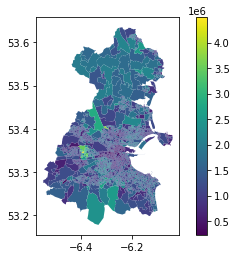

In [90]:
sa_dem_geom.plot(column='sa_demand_kwh', legend=True)

In [91]:
df = state.result[postcode_final].result

In [100]:
df

,postcode,energy_per_postcode_kwh,elec_per_postcode_kwh,heat_per_postcode_kwh
0,co. dublin,1.391489e+09,3.063941e+08,1.085095e+09
1,dublin 1,1.025146e+08,1.763942e+07,8.487520e+07
2,dublin 10,1.058939e+08,1.874926e+07,8.714461e+07
3,dublin 11,1.388721e+08,2.639961e+07,1.124725e+08
4,dublin 12,2.815912e+08,5.256000e+07,2.290311e+08
5,dublin 13,1.227166e+08,2.591338e+07,9.680319e+07
6,dublin 14,1.966456e+08,4.028934e+07,1.563562e+08
7,dublin 15,3.838384e+08,8.464938e+07,2.991890e+08
8,dublin 16,3.104005e+08,6.679087e+07,2.436096e+08
9,dublin 17,1.396581e+08,2.902427e+07,1.106338e+08


In [101]:
df.to_csv("idf/total_postcode_demands.csv")